# 1. Install and import libraries

In [ ]:
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install emoji
!pip install emot
!pip install clean-text[gpl]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=13105eb78453c9349d69af64c96c5bbd277a8ccb1363d5ba254d71d6d0b428c5
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from google.colab import drive
import os, io
import re
import pickle
import emoji
import emot.emo_unicode
from cleantext import clean
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/prompt_recc')

Mounted at /content/drive


#2. Data exploration

In [ ]:
# Load data
df = pd.read_csv("prompt_with_img_path.csv")
df.head()

,id,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,image_path
0,0,"a renaissance portrait of dwayne johnson, art ...",2480545905,50,16.0,k_euler_ancestral,512,768,e9dfc969d22cb9c5621ad075b3826c28f18ef3840c6dda...,2022-08-20 05:28:00+00:00,0.163488,0.000793,/content/drive/MyDrive/prompt_recc/Hyelim_firs...
1,1,"portrait of a dancing eagle woman, beautiful b...",2250159284,50,9.0,k_lms,512,640,aa60a36693bf9e079b421c1200fd42ed94061fb02078ad...,2022-08-20 05:28:00+00:00,0.276650,0.003090,/content/drive/MyDrive/prompt_recc/Hyelim_firs...
2,2,"epic 3 d, become legend shiji! gpu mecha contr...",4292948605,50,7.0,k_lms,512,768,3e774662f24c78b0590d57365d755d7dacde8f33dbdc56...,2022-08-20 05:28:00+00:00,0.090421,0.000533,/content/drive/MyDrive/prompt_recc/Hyelim_firs...
3,3,an airbrush painting of cyber war machine scen...,2374713726,50,12.0,k_lms,512,768,c2bd0b60caa0aa04d0a7e5972fefc60b21ece352d88353...,2022-08-20 05:29:00+00:00,0.078309,0.000597,/content/drive/MyDrive/prompt_recc/Hyelim_firs...
4,4,concept art of a silent hill monster. painted ...,2320897141,50,6.0,k_lms,640,512,08ac4153ab7e13baa55ee74213eb117a29a0024267b29e...,2022-08-20 05:29:00+00:00,0.086802,0.083516,/content/drive/MyDrive/prompt_recc/Hyelim_firs...


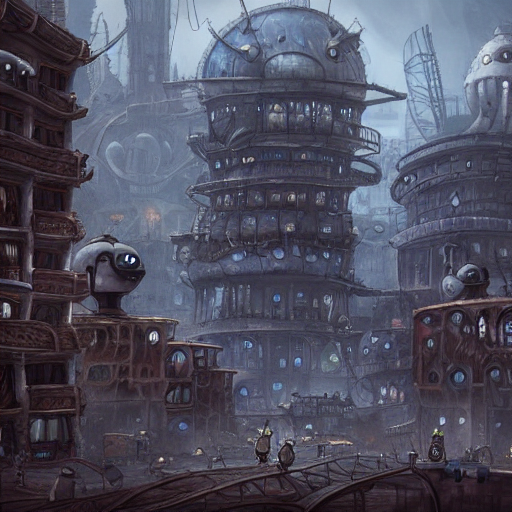

In [ ]:

image = Image.open(df['image_path'][4650])
display(image)
print(df['prompt'][4650])

In [ ]:
# Look at some random prompts
rand_num = np.random.randint(low = 0, high = len(df)-1, size = 50)
for i in rand_num:
  print('-------- index: ', i)
  print(df.loc[i][1])

-------- index:  4701
rodrigo duterte and ferdinand marcos jr. in hell, painted with watercolor, by rembrandt 
-------- index:  3097
🤳 🦊🦝 🏳🌈 
-------- index:  3534
cyborgs church, beautiful landscape, environment, colors, film, dramatic, cinematic, highly detailed, mid day, large scale, hyperrealistic, realistic lighting, octane render, by wlop, artgerm, trending on artstation, hd, 8 k, clear, sharp 
-------- index:  4054
blurry and dreamy screencap of a realistic character from 8 0 s horror anime, vampire woman with short hair and wearing dress suit with tie, satoshi kon anime, character design by yoshitaka amano and junji ito, glitchy vhs tape, night tokyo in the background, perfect blue color palette, noisy film grain effect, blurry image 
-------- index:  215
ink drawing by hokusai of a guinea pig. 
-------- index:  2285
anime full body portrait of a couple by artgerm, wlop, loish, ilya kuvshinov, and makoto shinkai, still from persona 5, elegant, vivid colors, hyperdetailed artist

A prompt with the index of 3097 has only emoji. So, we need to convert emoji to text. But, if an emoji is not convertible to texts, we remove it. Next, we remove stop words and apply stemming.

#3. Text preprocessing

In [ ]:
# Extract 'id' and 'prompt' columns
prompt = df[['id', 'prompt']]

# Remove data which don't have any text
prompt.drop(prompt[prompt['prompt'].isnull()].index, axis = 0, inplace = True)
prompt['prompt'].isnull().values.any()

<ipython-input-8-3777feb9d22e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prompt.drop(prompt[prompt['prompt'].isnull()].index, axis = 0, inplace = True)


False

## 3 (a) Convert emoji to word(s) or remove emoji if it's not convertible.

In [ ]:
# Step (a) Convert emoji to word(s)
with open('Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word_pd(row):
    if isinstance(row[1], str) and bool(emoji.emoji_count(row[1])):
      temp = row[1]
      for emot in Emoji_Dict:
          temp = re.sub(r'('+emot+')', " "+ " ".join(Emoji_Dict[emot].replace(",","").replace(":","").replace("_", " ").split()), temp)
      if bool(emoji.emoji_count(temp)):
          return clean(temp, no_emoji = True)
      else:
          return temp
    else:
      return row[1]

prompt['no_emojis'] = prompt.apply(convert_emojis_to_word_pd, axis = 1)
prompt.loc[[3288]]

<ipython-input-13-7dff690ef537>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prompt['no_emojis'] = prompt.apply(convert_emojis_to_word_pd, axis = 1)


,id,prompt,no_emojis
3288,3288,⛏🦊🐺 🚀 🌕 🏙,pick fox face wolf face rocket full moon c...


## 3 (b) Remove stop words and then apply stemming

In [ ]:
# Step (b) Remove stop words and stemming
stopwords = stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()

def remove_stopwords_stemming(row):
  special_characters = set(string.punctuation)
  text = ''.join(ch for ch in row[2] if ch not in special_characters and not ch.isnumeric())
  tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.lower() not in stopwords]
  after_stemming = [stemmer.stem(token) for token in tokens]
  return ' '.join(after_stemming)

prompt['after_stemming'] = prompt.apply(remove_stopwords_stemming, axis = 1)
prompt.head()

<ipython-input-14-0bcd37c04c35>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prompt['after_stemming'] = prompt.apply(remove_stopwords_stemming, axis = 1)


,id,prompt,no_emojis,after_stemming
0,0,"a renaissance portrait of dwayne johnson, art ...","a renaissance portrait of dwayne johnson, art ...",renaiss portrait dwayn johnson art style rembr...
1,1,"portrait of a dancing eagle woman, beautiful b...","portrait of a dancing eagle woman, beautiful b...",portrait danc eagl woman beauti blond hair lak...
2,2,"epic 3 d, become legend shiji! gpu mecha contr...","epic 3 d, become legend shiji! gpu mecha contr...",epic becom legend shiji gpu mecha control tele...
3,3,an airbrush painting of cyber war machine scen...,an airbrush painting of cyber war machine scen...,airbrush paint cyber war machin scene area des...
4,4,concept art of a silent hill monster. painted ...,concept art of a silent hill monster. painted ...,concept art silent hill monster paint edward h...


## 3 (c) Add word count column

In [ ]:
# Step (c) Add word count column
def word_count(row):
  temp = row[3]
  return len([s for s in temp.split(' ') if not s.isnumeric()])

prompt['word_count'] = prompt.apply(word_count, axis = 1)

<ipython-input-15-31778a2b7de7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prompt['word_count'] = prompt.apply(word_count, axis = 1)


In [ ]:
prompt.head()

,id,prompt,no_emojis,after_stemming,word_count
0,0,"a renaissance portrait of dwayne johnson, art ...","a renaissance portrait of dwayne johnson, art ...",renaiss portrait dwayn johnson art style rembr...,27
1,1,"portrait of a dancing eagle woman, beautiful b...","portrait of a dancing eagle woman, beautiful b...",portrait danc eagl woman beauti blond hair lak...,36
2,2,"epic 3 d, become legend shiji! gpu mecha contr...","epic 3 d, become legend shiji! gpu mecha contr...",epic becom legend shiji gpu mecha control tele...,26
3,3,an airbrush painting of cyber war machine scen...,an airbrush painting of cyber war machine scen...,airbrush paint cyber war machin scene area des...,15
4,4,concept art of a silent hill monster. painted ...,concept art of a silent hill monster. painted ...,concept art silent hill monster paint edward h...,8


In [ ]:
# Remove data that has null or '' after stemming
df2 = prompt.copy()
index_to_drop = df2[df2['after_stemming'] == ''].index
df2.drop(index_to_drop , inplace=True)
df2[df2['word_count'] < 2]

,id,prompt,no_emojis,after_stemming,word_count
100,100,variegated,variegated,varieg,1
127,127,undefined,undefined,undefin,1
134,134,fonts,fonts,font,1
138,138,sadsadsadsadsadsadsadsadsadsadsadsadsadsadsad,sadsadsadsadsadsadsadsadsadsadsadsadsadsadsad,sadsadsadsadsadsadsadsadsadsadsadsadsadsadsad,1
217,217,a can of heinz.,a can of heinz.,heinz,1
484,484,prelude,prelude,prelud,1
489,489,prelude,prelude,prelud,1
494,494,crystal,crystal,crystal,1
503,503,dadaism,dadaism,dadaism,1
511,511,impressionism,impressionism,impression,1


## 3 (d) Save the preprocessing dataframe as csv file

In [ ]:
df2.to_csv('/content/drive/MyDrive/prompt_recc/'+'clean_text_only.csv', index = False)
df2.to_csv('Hyelim_5k_pre_processed.csv')